In [83]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import missingno as msno
import seaborn as sns
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore') 

In [76]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [62]:
# Model selection and evaluation tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import statsmodels.api as sm

In [6]:
import sys
sys.path.insert(0, '../')
from statlearning import plot_coefficients

In [7]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

# The Clairvoyant Constructor Analysis

You work at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like you to work on forecasting core construction material costs. 

You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format.

Currently, the company is able to purchase futures contracts in a material for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase. 

# Data Wrangling

In [19]:
df = pd.read_csv('construction_material_prices_2008_2018.csv')
print('Number of rows:',len(df))

Number of rows: 2945


In [20]:
df.head()

,Unnamed: 0,price_steel,price_rebar,price_glass,price_concrete,price_plywood
0,2007-01-01,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,NaN,NaN,NaN,NaN,NaN
3,2007-01-05,NaN,NaN,NaN,NaN,NaN
4,2007-01-08,NaN,NaN,NaN,NaN,NaN


In [21]:
df.dtypes

Unnamed: 0         object
price_steel       float64
price_rebar       float64
price_glass       float64
price_concrete    float64
price_plywood     float64
dtype: object

In [22]:
df['Date'] = pd.to_datetime(df['Unnamed: 0'])
df.drop('Unnamed: 0', axis=1, inplace=True)

In [23]:
df['cum_days'] = range(1, len(df) + 1)
df['year']=df['Date'].apply(lambda x: x.year)
df['month']=df['Date'].apply(lambda x: x.month)
df['day']=df['Date'].apply(lambda x: x.day)
df['weekday']=df['Date'].apply(lambda x: x.weekday())

In [24]:
df.set_index('Date', inplace=True)

In [25]:
df2 = df[['price_steel','price_rebar','price_glass','price_concrete','price_plywood']]
df2.describe()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
count,2309.000000,1649.000000,1472.000000,1447.000000,2673.000000
mean,12.611319,18.306339,29.997962,26.000636,12.775067
std,6.038862,8.587938,6.524622,7.314764,3.931698
min,3.062500,3.000000,16.000000,10.416667,5.000000
25%,8.500000,12.071429,25.000000,20.559028,10.125000
50%,10.500000,16.500000,29.000000,25.043478,12.125000
75%,14.833333,22.500000,35.000000,30.000000,14.333333
max,41.000000,55.000000,48.000000,50.000000,34.000000


In [37]:
# checking missing data in data 
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
price_concrete,1498,50.865874
price_glass,1473,50.016978
price_rebar,1296,44.006791
price_steel,636,21.595925
price_plywood,272,9.235993


In [39]:
print("Percent of missing data per column:")
100*df.isna().sum()/len(df)

Percent of missing data per column:


price_steel       21.595925
price_rebar       44.006791
price_glass       50.016978
price_concrete    50.865874
price_plywood      9.235993
cum_days           0.000000
year               0.000000
month              0.000000
day                0.000000
weekday            0.000000
dtype: float64

A lot of missing values.

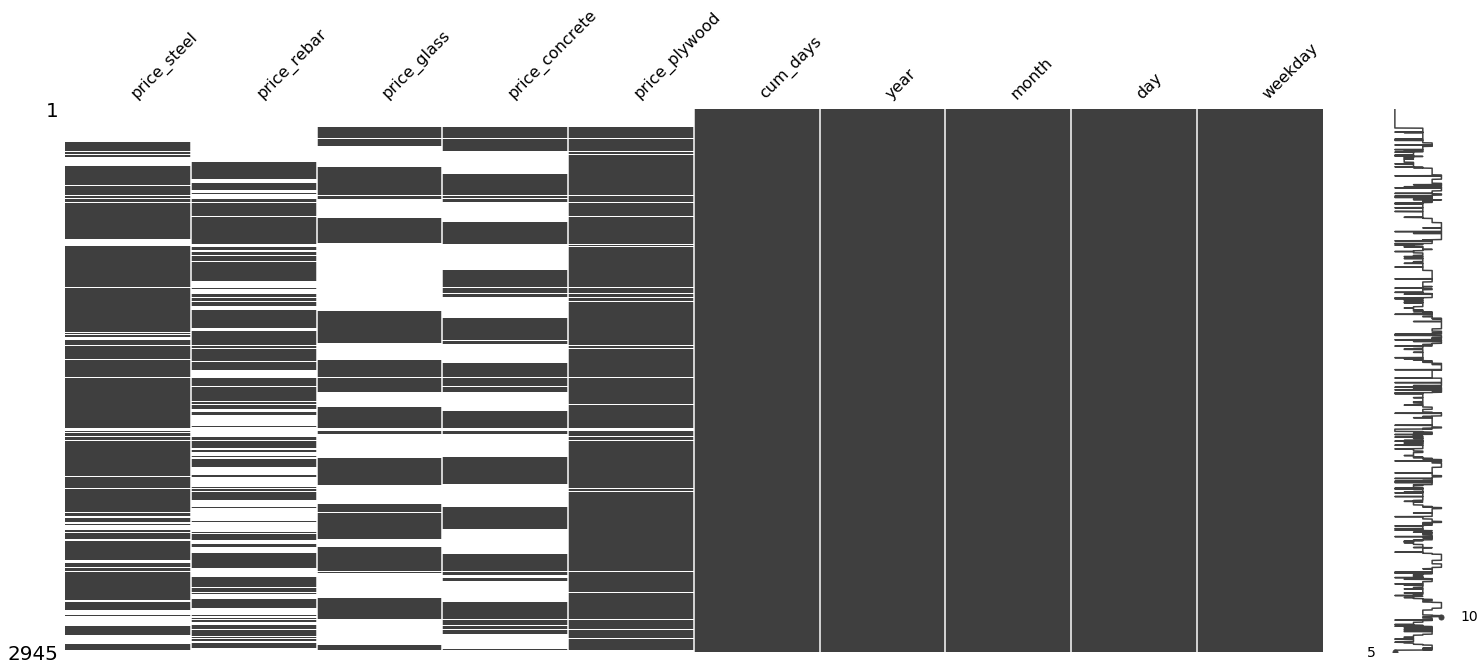

In [27]:
msno.matrix(df);

In [28]:
df.head()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood,cum_days,year,month,day,weekday
datetime,,,,,,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN,1,2007,1,1,0
2007-01-03,NaN,NaN,NaN,NaN,NaN,2,2007,1,3,2
2007-01-04,NaN,NaN,NaN,NaN,NaN,3,2007,1,4,3
2007-01-05,NaN,NaN,NaN,NaN,NaN,4,2007,1,5,4
2007-01-08,NaN,NaN,NaN,NaN,NaN,5,2007,1,8,0


# EDA

In [53]:
def plot_ts(df, col_name, new_fig=True):
    
    if new_fig == True:
        plt.figure(figsize=(20,20))
    
    ax1 = plt.subplot(411)
    plt.plot(df[col_name]);
    ax1.set_xticks([], minor=True) 
    sns.despine()

    ax2 = plt.subplot(412)
    plt.plot(df.groupby('month').mean()[col_name]);
    ax2.set_xticks([], minor=True) 
    sns.despine()

    ax3 = plt.subplot(413)
    plt.plot(df.groupby('day').mean()[col_name]);
    ax3.set_xticks([], minor=True) 
    sns.despine()

    ax4 = plt.subplot(414)
    plt.plot(df.groupby('weekday').mean()[col_name]);
    ax4.set_xticks([], minor=True) 
    sns.despine()

    ax1.title.set_text(col_name + ' over time')
    #ax2.title.set_text('Day of Year')
    ax2.title.set_text('Month of year')
    ax3.title.set_text('Day of month')
    ax4.title.set_text('Weekday')

## Steel Time Series

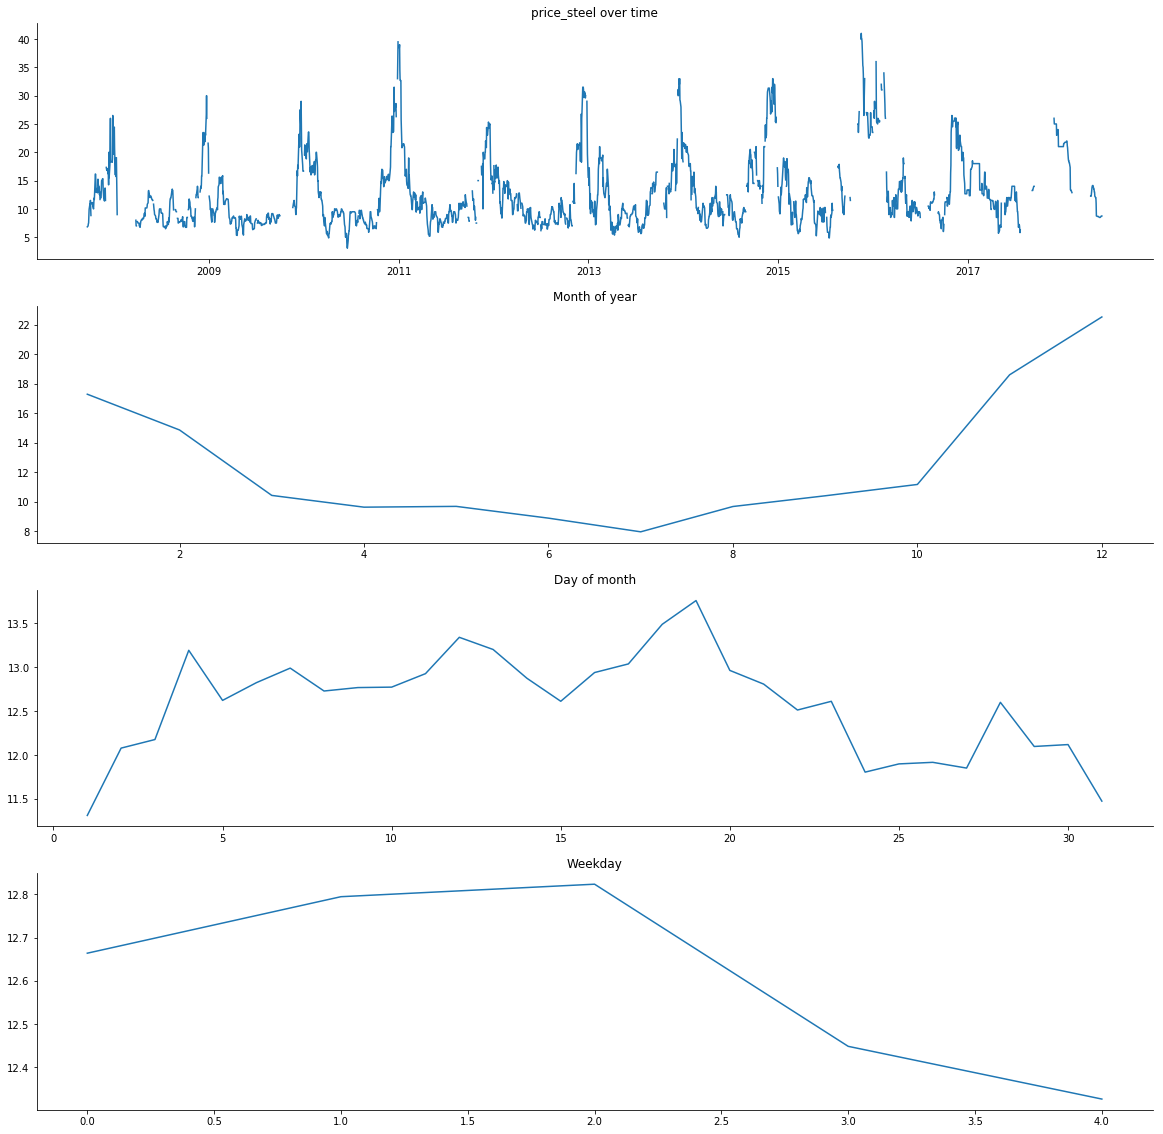

In [56]:
plot_ts(df, 'price_steel')

## Rebar Time Series

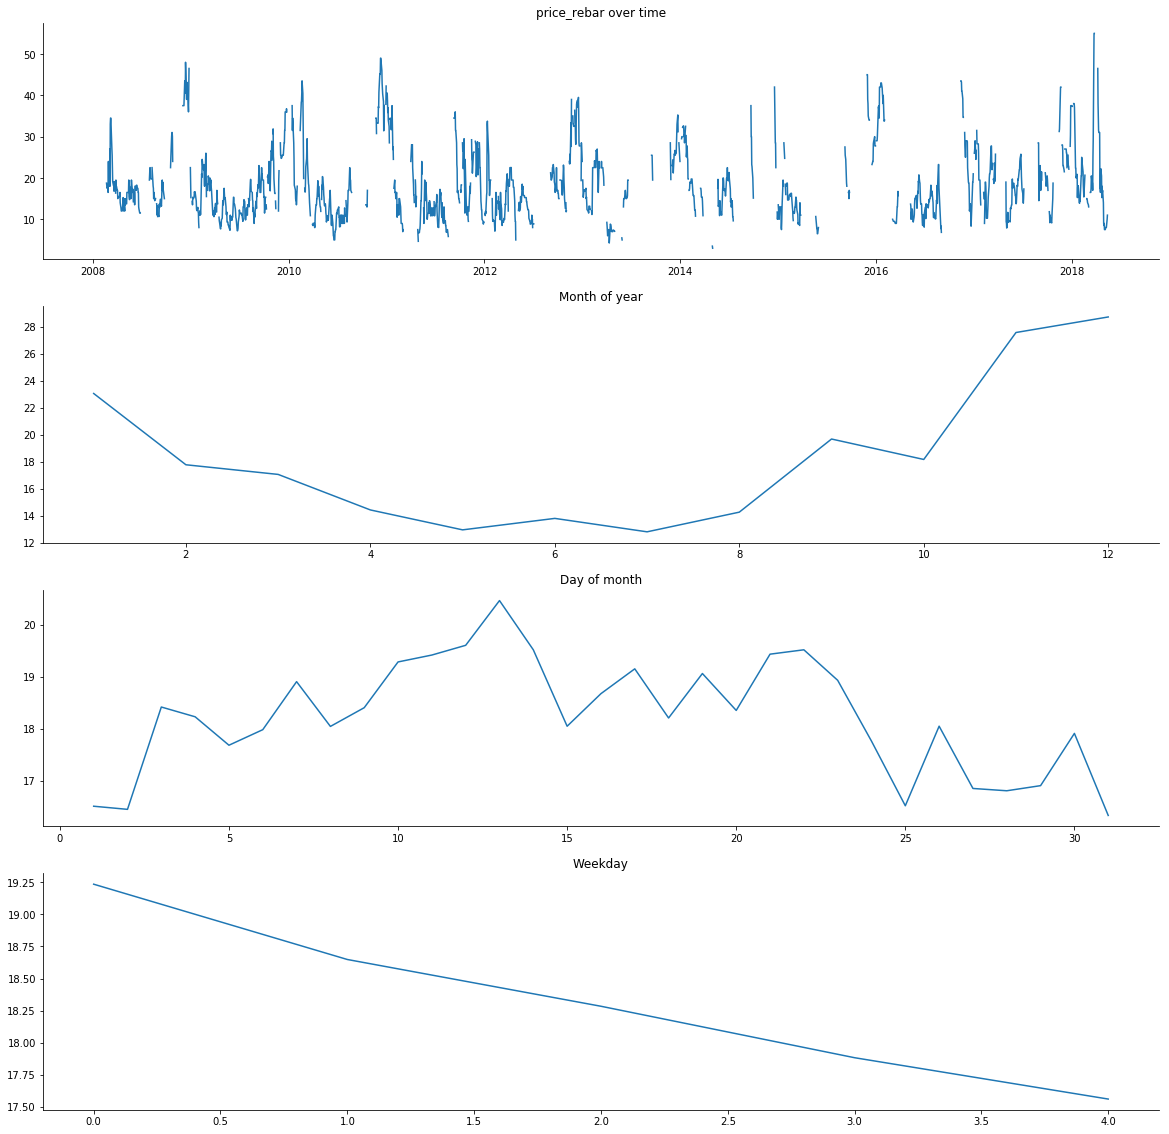

In [57]:
plot_ts(df, 'price_rebar')

## Glass Time Series

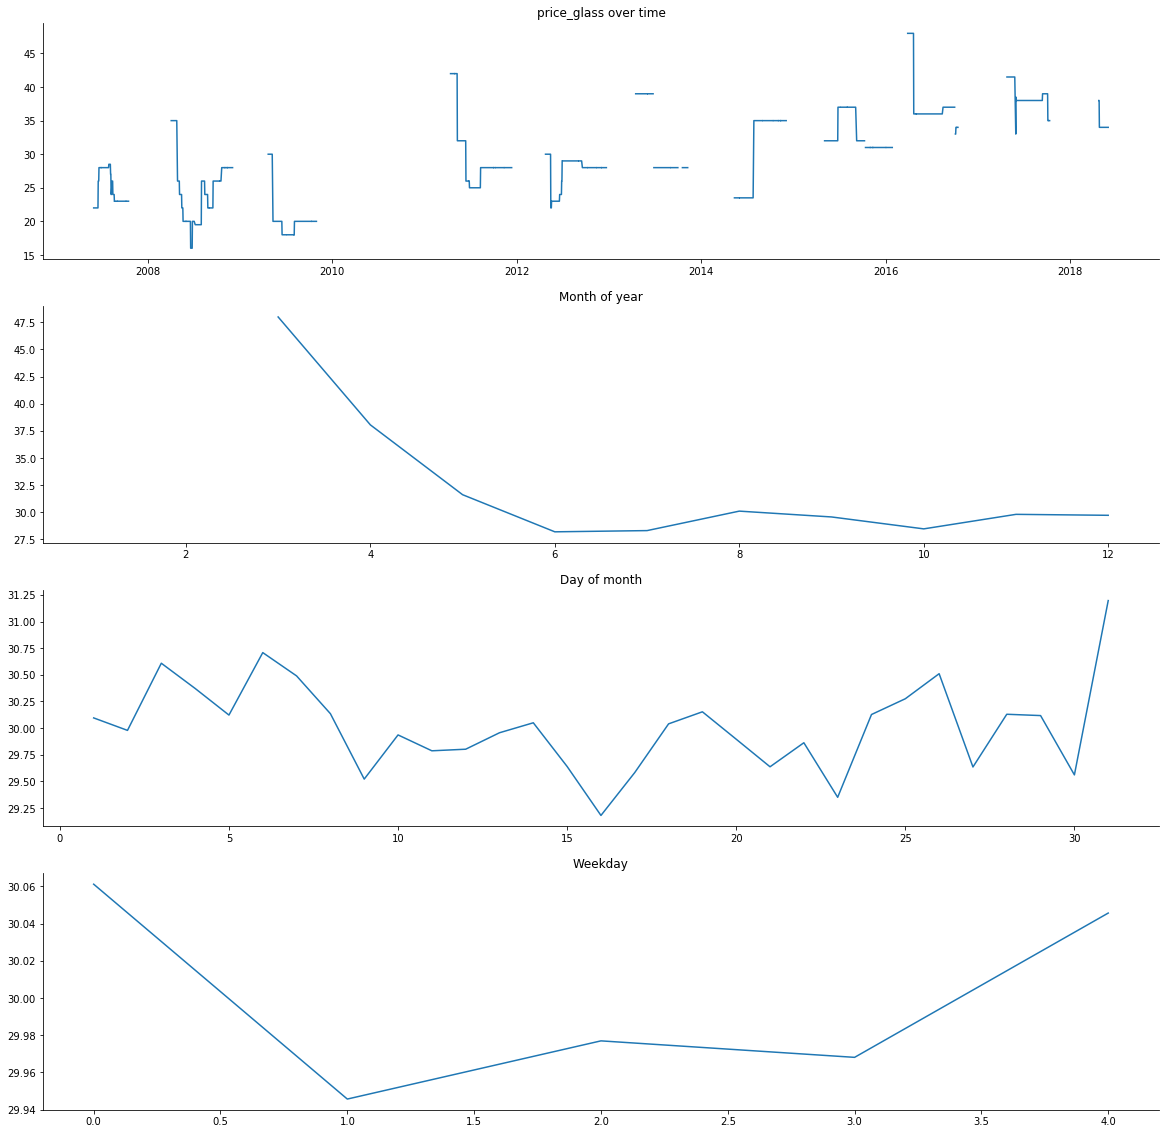

In [58]:
plot_ts(df, 'price_glass')

## Concrete Time Series

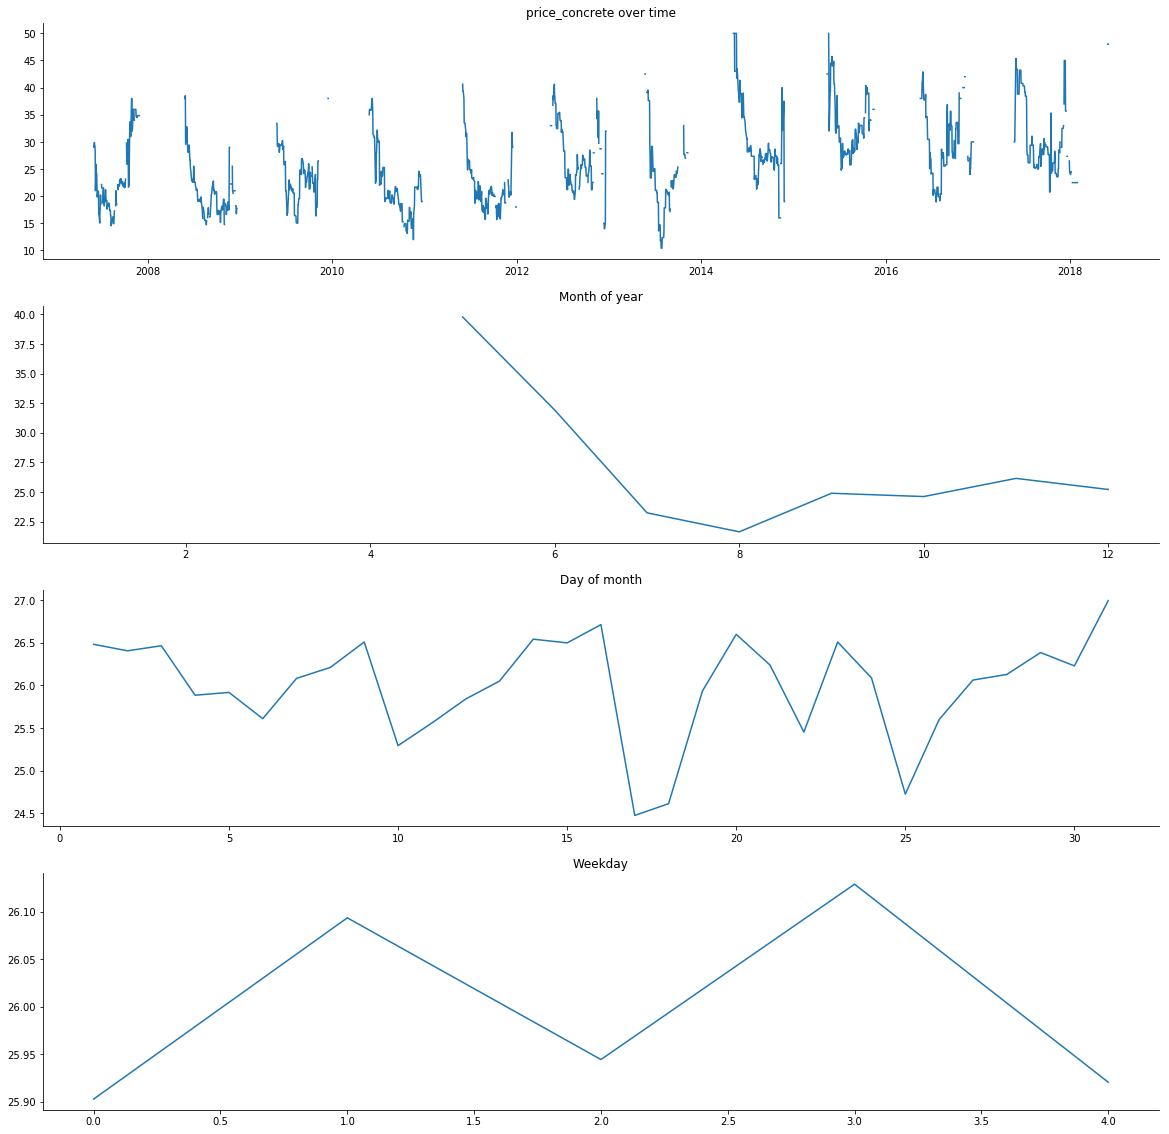

In [59]:
plot_ts(df, 'price_concrete')

## Plywood Time Series

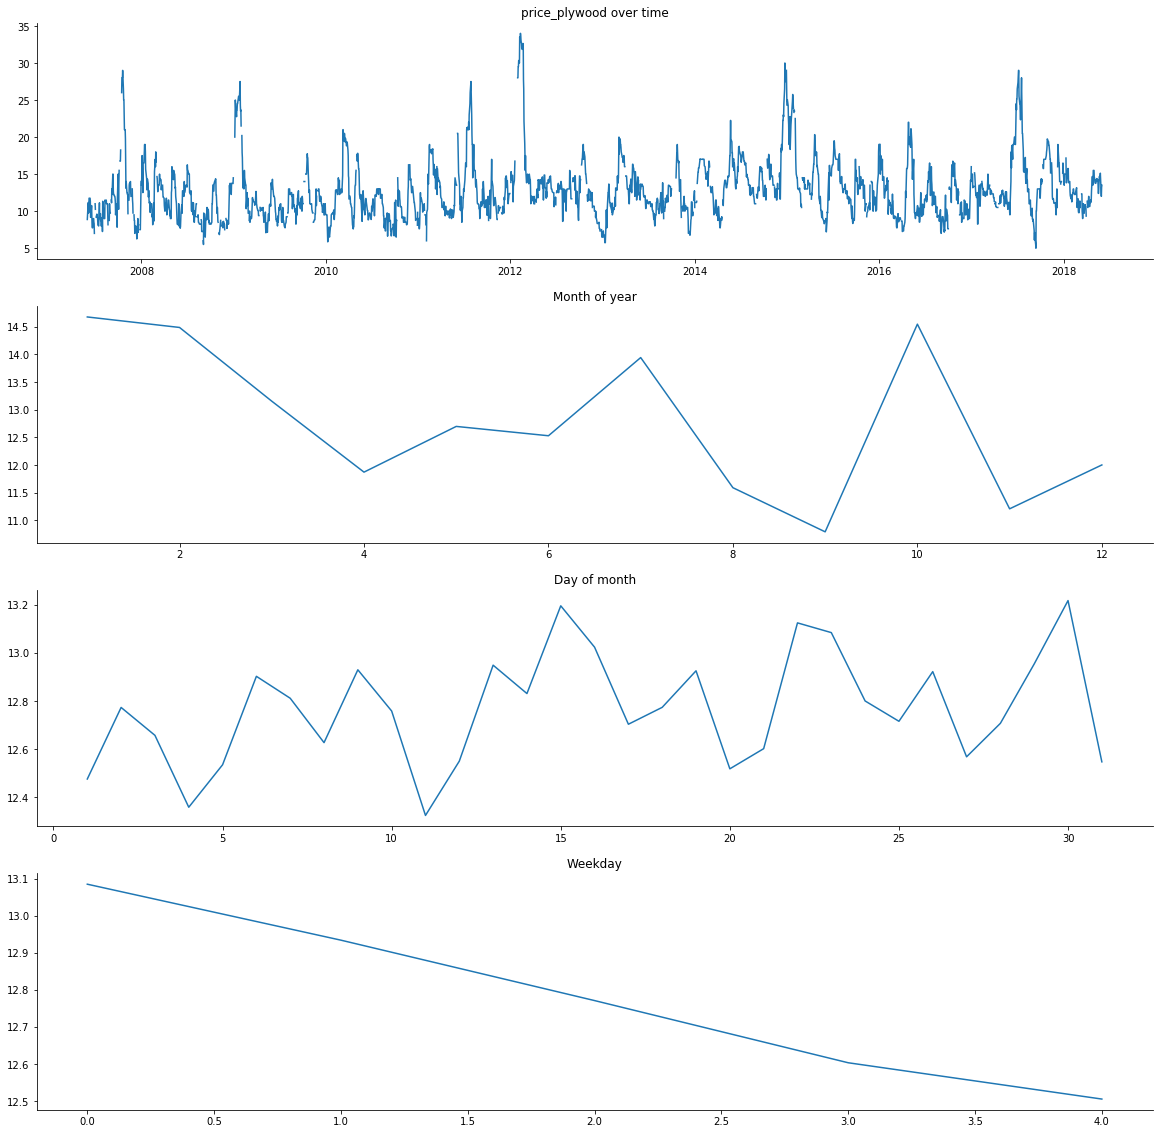

In [61]:
plot_ts(df, 'price_plywood')

* From these graphs, we observe:
    1. A lot of cyclic behavior from the spikes. 
    2. A large number of missing data in all the commodities but plywood.
    
*We will focus on plywood prices*

# ARIMA model identification

In [65]:
cleaned_df = df.dropna()
len(cleaned_df)

512

In [69]:
y = cleaned_df['price_plywood']
len(y)

512

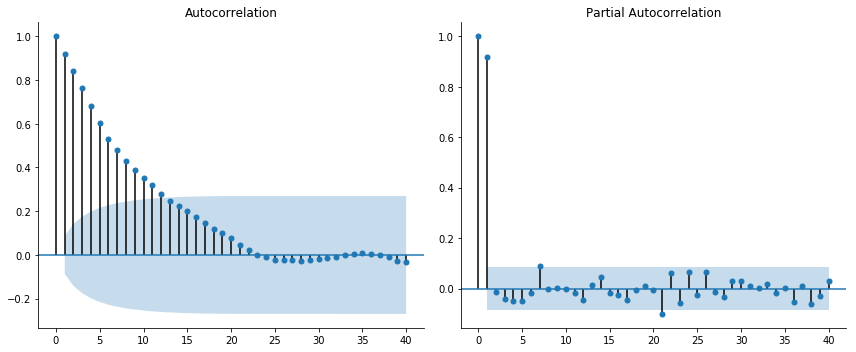

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

The autocorrelations decay slowly, reflecting the non-stationarity of the series.

In [70]:
diff=y-y.shift(1)
diff=diff.dropna()

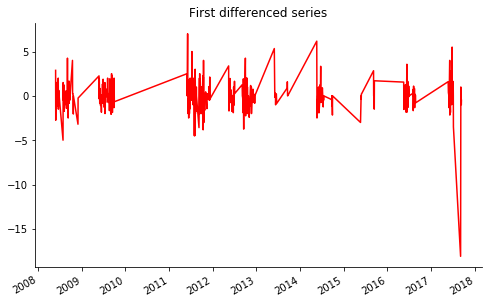

In [72]:
fig, ax= plt.subplots(figsize=(8,5))
diff.plot(color='red')
ax.set_xlabel('')
ax.set_title('First differenced series')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

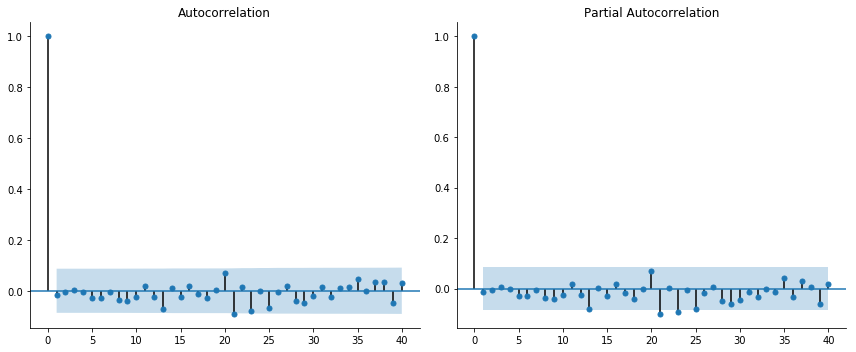

In [73]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

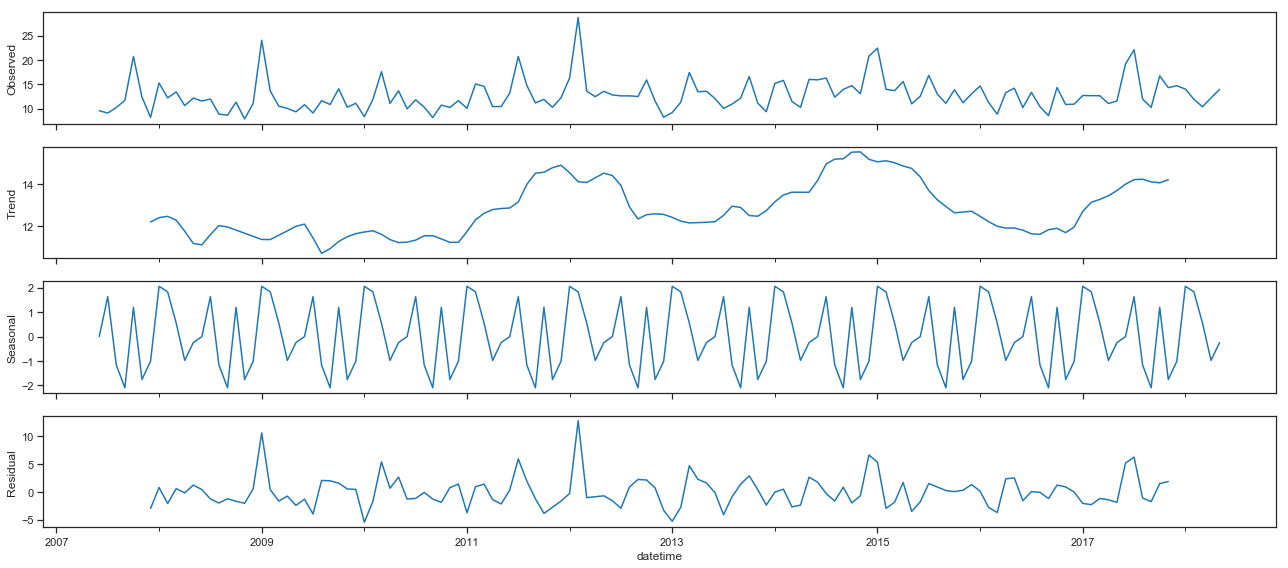

In [79]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plywood_mean = df['price_plywood'].dropna().resample('M').mean().dropna()
decomposition = sm.tsa.seasonal_decompose(plywood_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [99]:
def grid_search(pdq, df, col_name):
    %%time
    best_AIC = 100000
    best_params = 0

    df_mean = df[col_name].dropna().resample('M').mean().dropna()
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df_mean,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

                if results.aic < best_AIC:
                    best_AIC = results.aic
                    best_params = '{}x{}'.format(param, param_seasonal)
            except:
                continue

    print('-'*50)
    print(col_name)
    print('Best AIC: {}'.format(best_AIC))
    print('Best params: {}'.format(best_params))
    return best_params

In [100]:
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [101]:
best_params = grid_search(pdq, df, 'price_plywood')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
--------------------------------------------------
price_plywood
Best AIC: 558.265011419576
Best params: (0, 0, 1)x(0, 1, 1, 12)


In [102]:
sarimax = sm.tsa.statespace.SARIMAX(plywood_mean,
                                            order=(0, 0, 1),
                                            seasonal_order= (0, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
trained_model = sarimax.fit()

In [103]:
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                      price_plywood   No. Observations:                  132
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -276.133
Date:                            Sun, 06 Jan 2019   AIC                            558.265
Time:                                    18:37:37   BIC                            566.255
Sample:                                06-30-2007   HQIC                           561.504
                                     - 05-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3959      0.074      5.363      0.000       0.251       0.541
ma.S.L12      -1.0000    763.913     -0.001      0.999   -1498.242    1496.242
sigma2         8.8513   6762.340      0.001      0.999   -1.32e+04    1.33e+04
===================================================================================
Ljung-Box (Q):                       44.44   Jarque-Bera (JB):                74.11
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""